In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from torchinfo import summary
import torch.nn as nn
import argparse, os, json, sys
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import h5py
from EvalTools import *
sys.path.append("../model")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
import gc
import glob
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
dataset = 'jetnet'
results_dir = 'results/'
result_files = [f for f in os.listdir(results_dir) if dataset in f]
print('\n'.join(result_files))

RESULTS_UQPFIN_best_jetnet_nominal_0.6_skipwz.h5
RESULTS_UQPFIN_best_jetnet_0.5_skipwz_ocmodel.h5
RESULTS_UQPFIN_best_jetnet_0.1_skipwz_ocmodel.h5
RESULTS_UQPFIN_best_jetnet_nominal_0.1_skiptop.h5
RESULTS_UQPFIN_best_jetnet_nominal_0.5_skipwz.h5
RESULTS_UQPFIN_Ensemble_jetnet_skipwz.h5
RESULTS_UQPFIN_best_jetnet_0_skipwz.h5
RESULTS_UQPFIN_best_jetnet_nominal_0.6_skiptwz.h5
RESULTS_UQPFIN_best_jetnet_0.5_baseline_ocmodel.h5
RESULTS_UQPFIN_best_jetnet_0.7_skipwz.h5
RESULTS_UQPFIN_best_jetnet_nominal_0.7_skipwz_ocmodel.h5
RESULTS_UQPFIN_best_jetnet_nominal_1.0_skiptwz.h5
RESULTS_UQPFIN_best_jetnet_nominal_0.1_skiptwz.h5
RESULTS_UQPFIN_Ensemble_jetnet_baseline.h5
RESULTS_UQPFIN_best_jetnet_0.7_skiptop_ocmodel.h5
RESULTS_UQPFIN_best_jetnet_0.1_skiptop_ocmodel.h5
RESULTS_UQPFIN_best_jetnet_nominal_1.0_skiptop.h5
RESULTS_UQPFIN_MCDO_jetnet_skipwz.h5
RESULTS_UQPFIN_Ensemble_jetnet_skiptwz.h5
RESULTS_UQPFIN_best_jetnet_0.1_baseline_ocmodel.h5
RESULTS_UQPFIN_best_jetnet_nominal_0.1_skipwz.h5
RES

In [4]:
tags = []
for modelname in result_files:
    if "Ensemble" in modelname or "MCDO" in modelname:
        tag = modelname.strip().split('_')[-1][:-3]
        if tag not in tags:
            tags.append(tag)
print("\n".join(tags))

skipwz
baseline
skiptwz
skiptop


skipwz


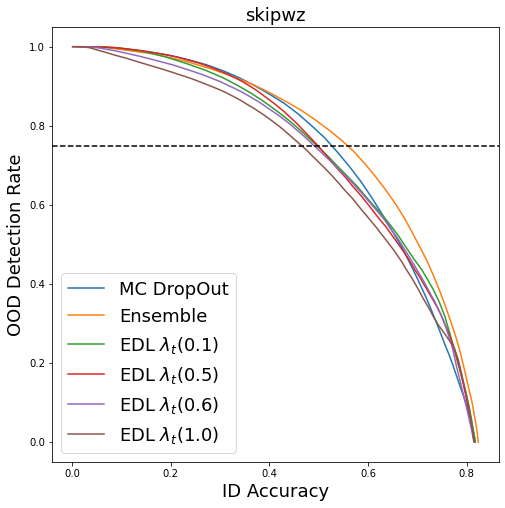

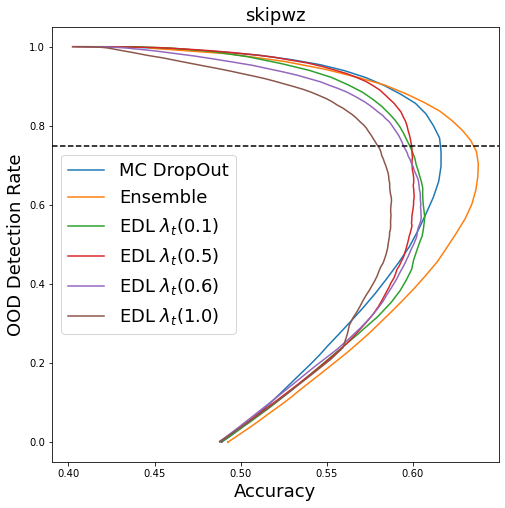

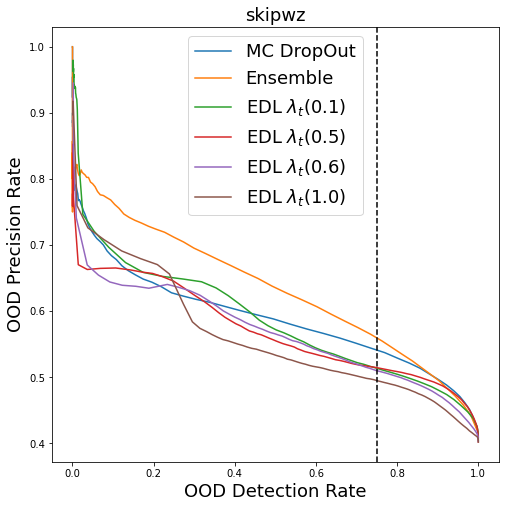

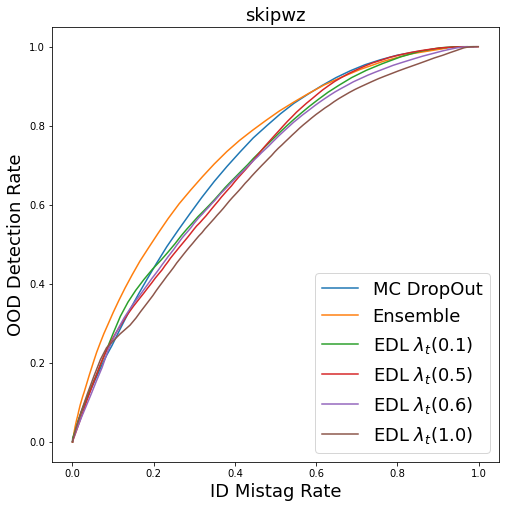

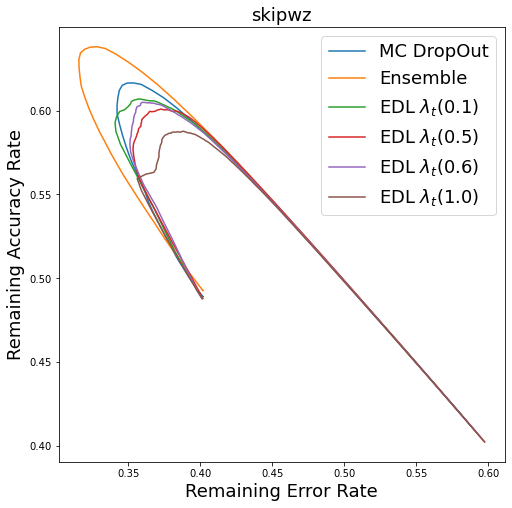




baseline


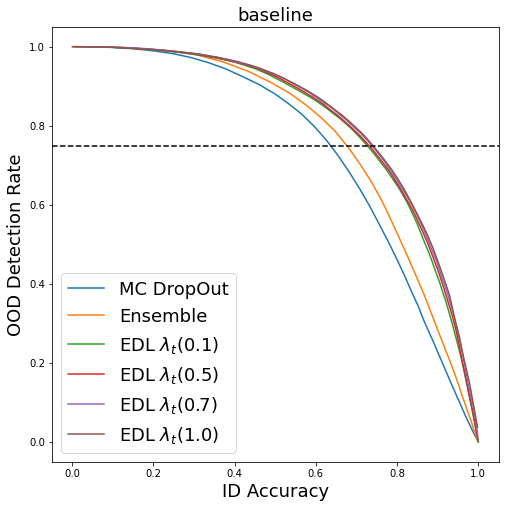

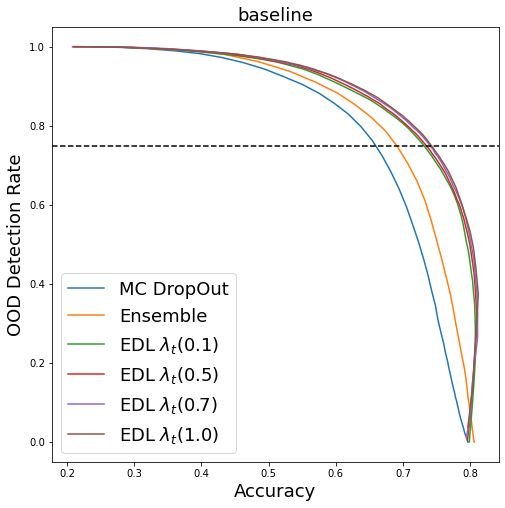

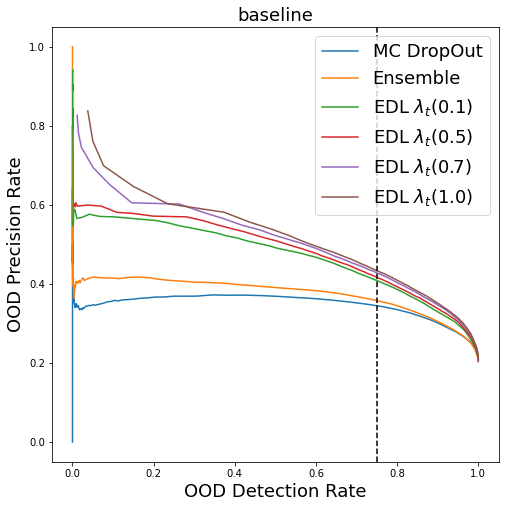

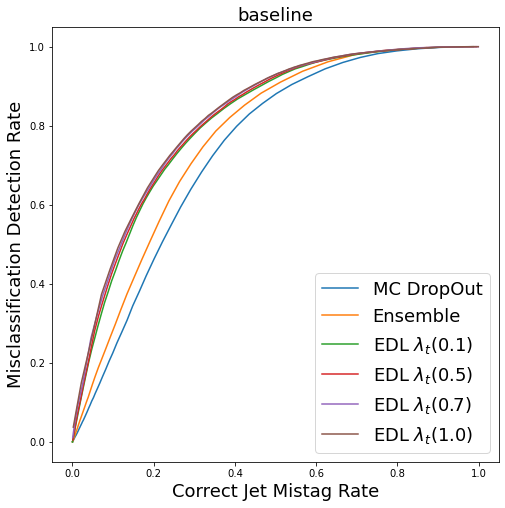

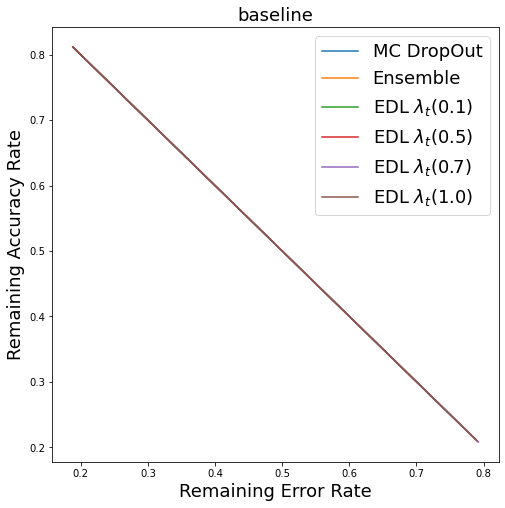




skiptwz


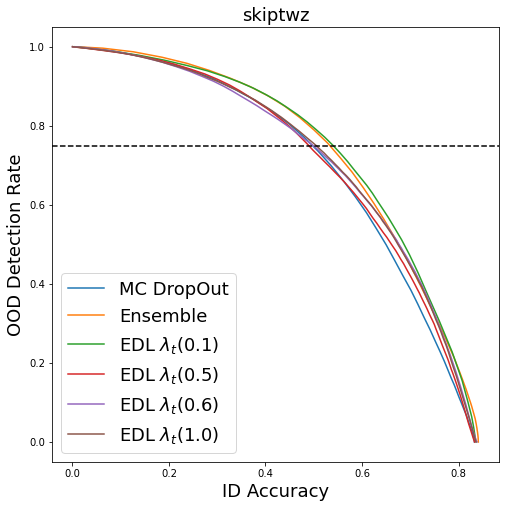

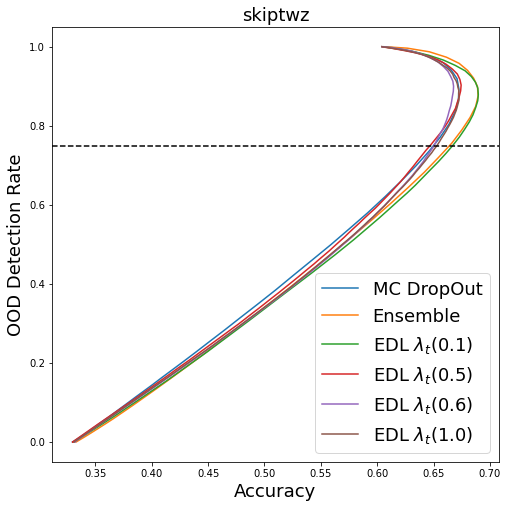

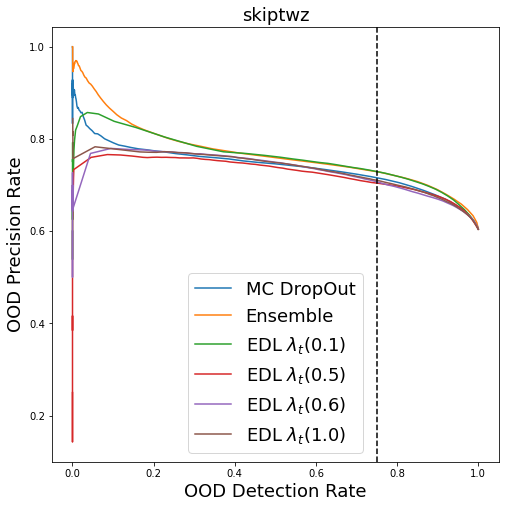

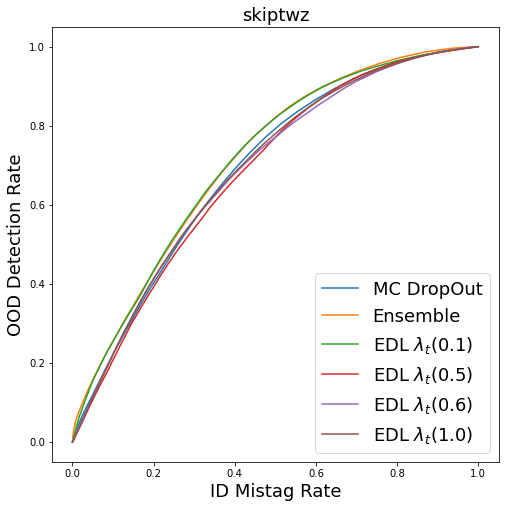

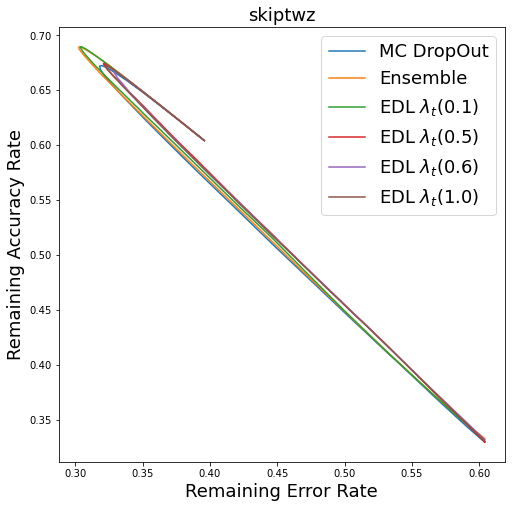




skiptop


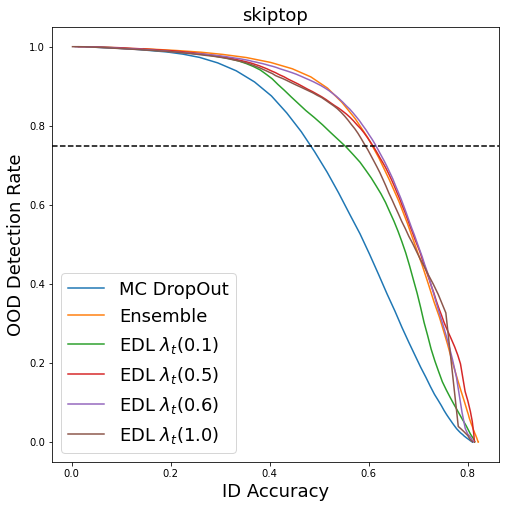

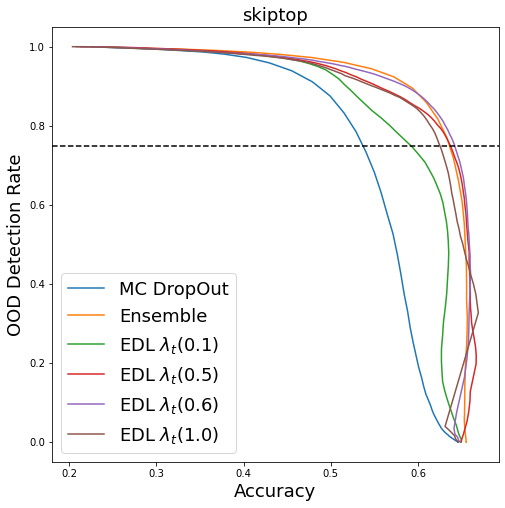

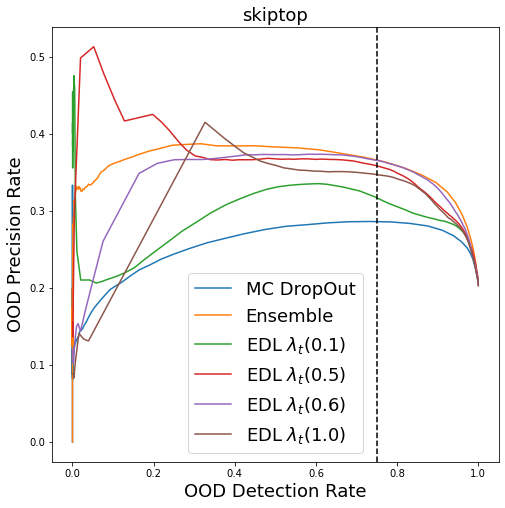

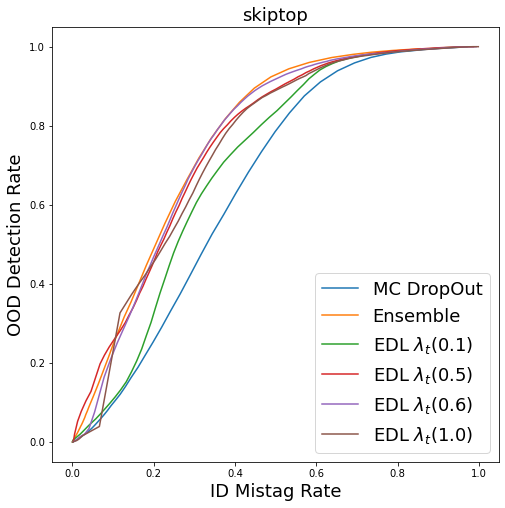

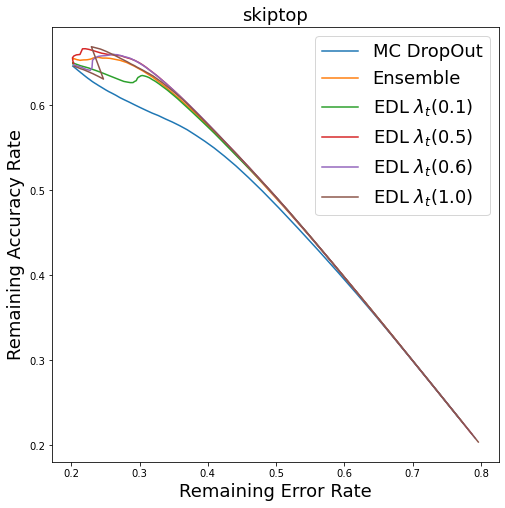

In [5]:
for tag in tags:
    print(tag)
    model_results = {}
    plotter_map = {}
    
    fnames = ["RESULTS_UQPFIN_MCDO_" + dataset + "_{}.h5",
              "RESULTS_UQPFIN_Ensemble_" + dataset + "_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_nominal_0.1_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_nominal_0.5_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_nominal_0.7_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_nominal_1.0_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.1_{}_ocmodel.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.5_{}_ocmodel.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.7_{}_ocmodel.h5",
              ]
    fnames = [os.path.join(results_dir, f) for f in fnames]
    types = ["MC DropOut", "Ensemble", r"EDL $\lambda_t (0.1)$", r"EDL $\lambda_t (0.5)$", r"EDL $\lambda_t (0.7)$", r"EDL $\lambda_t (1.0)$",
             r"EDL-CT $\lambda_t^{\texttt{CT}} (0.1)$", r"EDL-CT $\lambda_t^{\texttt{CT}} (0.5)$", r"EDL-CT $\lambda_t^{\texttt{CT}} (0.7)$" ]
            
    if dataset != "topdata":
        fnames = fnames[0: len(fnames) - 3]
        types = types[0: len(types) - 3]
    
    if dataset == "jetclass":
        fnames = [f.replace("nominal_1.0_{}", "nominal_v*_{}") for f in fnames]
        fnames = [f.replace("0.1_{}", "0.1_v*_{}") for f in fnames]
        fnames = [f for f in fnames if "0.5" not in f and "0.7" not in f]
        types = [t for t in types if "0.5" not in t and "0.7" not in t]
        
    if "skip" in tag:
        fnames[4] = fnames[4].replace("0.7", "0.6")
        types[4] = types[4].replace("0.7", "0.6")
                
    for ii, fname in enumerate(fnames):
        fname = glob.glob(fname.format(tag))[-1]
        f = h5py.File(fname, "r")
        model_results[types[ii]] = {'labels' : f['labels'][:], 
                                   'preds': f['preds'][:], 
                                   'maxprobs': f['maxprobs'][:],
                                   'sums':f['sums'][:], 
                                   'oods':f['oods'][:],
                                   'uncs': f['uncs'][:],
                                   'probs': f['probs'][:]}
        if tag == "baseline":
            model_results[types[ii]]['oods'] = f['labels'][:] != f['preds'][:]
        f.close()
        plotter_map[types[ii]] = PlotterTools(model_results[types[ii]], types[ii])
        
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].ODR_IDAcc(ax)
    ax.axhline(0.75, color = "k", linestyle= "--")
    ax.legend(fontsize = 18)
    ax.set_ylabel("OOD Detection Rate", fontsize = 18)
    ax.set_xlabel("ID Accuracy", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].ODR_Acc(ax)
    ax.axhline(0.75, color = "k", linestyle= "--")
    ax.legend(fontsize = 18)
    ax.set_ylabel("OOD Detection Rate", fontsize = 18)
    ax.set_xlabel("Accuracy", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].OCR_ODR(ax)
    ax.axvline(0.75, color = "k", linestyle= "--")
    ax.legend(fontsize = 18)
    ax.set_xlabel("OOD Detection Rate", fontsize = 18)
    ax.set_ylabel("OOD Precision Rate", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()
    
    
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].ODR_IMR(ax)
    ax.legend(fontsize = 18)
    if "skip" in tag:
        ax.set_ylabel("OOD Detection Rate", fontsize = 18)
        ax.set_xlabel("ID Mistag Rate", fontsize = 18)
    else:
        ax.set_ylabel("Misclassification Detection Rate", fontsize = 18)
        ax.set_xlabel("Correct Jet Mistag Rate", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    # fig.savefig("figures/"+dataset+"_"+tag+".pdf",  dpi = 150, bbox_inches='tight')
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].RAR_RER(ax)
    ax.legend(fontsize = 18)
    ax.set_ylabel("Remaining Accuracy Rate", fontsize = 18)
    ax.set_xlabel("Remaining Error Rate", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()
    
    print('\n\n')
    del model_results
    gc.collect()

skipwz


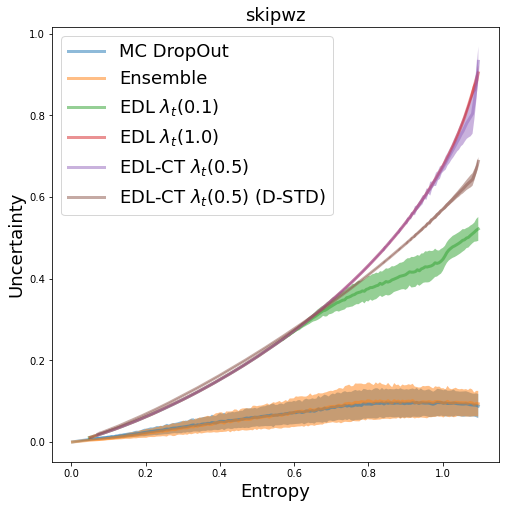




baseline


/scratch/bbuw/akhot2/final_uqad/PFIN4UQAD/evaluation/EvalTools.py:474: RuntimeWarning: Mean of empty slice.
  bin_means = np.array([y[digitized == i].mean() for i in range(1, len(bins))])
/u/akhot2/.conda/envs/uqad/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/u/akhot2/.conda/envs/uqad/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/u/akhot2/.conda/envs/uqad/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/u/akhot2/.conda/envs/uqad/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


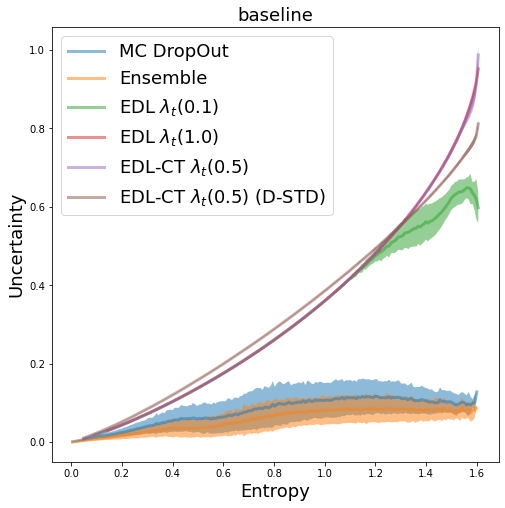




skiptwz


/scratch/bbuw/akhot2/final_uqad/PFIN4UQAD/evaluation/EvalTools.py:474: RuntimeWarning: Mean of empty slice.
  bin_means = np.array([y[digitized == i].mean() for i in range(1, len(bins))])
/u/akhot2/.conda/envs/uqad/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/u/akhot2/.conda/envs/uqad/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/u/akhot2/.conda/envs/uqad/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/u/akhot2/.conda/envs/uqad/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/scratch/bbuw/akhot2/final_uqad/PFIN4UQAD/evaluation/

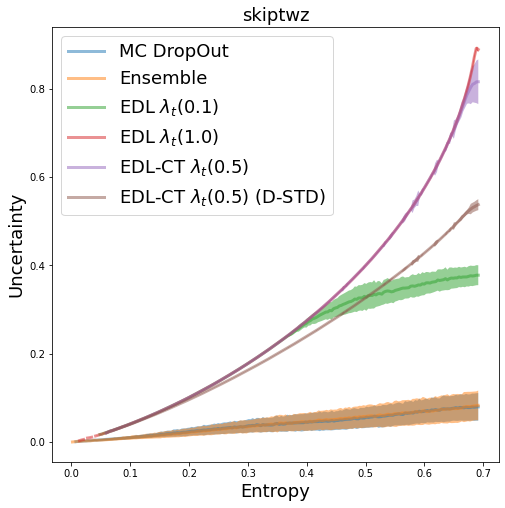




skiptop


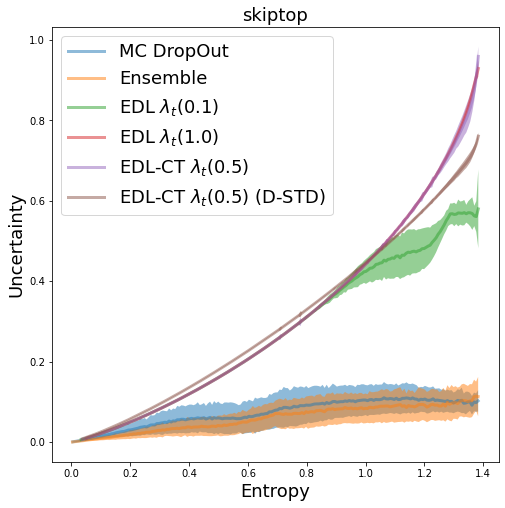

In [6]:
for tag in tags:
    print(tag)
    model_results = {}
    plotter_map = {}
    
    fnames = ["RESULTS_UQPFIN_MCDO_" + dataset + "_{}.h5",
              "RESULTS_UQPFIN_Ensemble_" + dataset + "_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.1_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_nominal_1.0_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.5_{}_ocmodel.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.5_{}_ocmodel.h5",
              ]
    fnames = [os.path.join(results_dir, f) for f in fnames]
    types = ["MC DropOut", "Ensemble", r"EDL $\lambda_t (0.1)$", r"EDL $\lambda_t (1.0)$", 
             r"EDL-CT $\lambda_t (0.5)$", r"EDL-CT $\lambda_t (0.5)$ (D-STD)" ]
            
    if dataset != "jetnet":
        fnames = fnames[0: len(fnames) - 2]
        types = types[0: len(types) - 2]
    
    if dataset == "topdata" or dataset == "jetclass":
        fnames.append(os.path.join(results_dir, "RESULTS_UQPFIN_best_" + dataset + "_nominal_0.1_{}.h5"))
        types.append(r"EDL $\lambda_t (0.1)$ (D-STD)")
        fnames.append(os.path.join(results_dir, "RESULTS_UQPFIN_best_" + dataset + "_nominal_1.0_{}.h5"))
        types.append(r"EDL $\lambda_t (1.0)$ (D-STD)")
        
    if dataset == "jetclass":
        fnames = [f.replace("nominal_1.0_{}", "nominal_v*_{}") for f in fnames]
        fnames = [f.replace("0.1_{}", "0.1_v*_{}") for f in fnames]
                
    for ii, fname in enumerate(fnames):
        fname = glob.glob(fname.format(tag))[-1]
        f = h5py.File(fname, "r")
        model_results[types[ii]] = {'labels' : f['labels'][:], 
                                   'preds': f['preds'][:], 
                                   'maxprobs': f['maxprobs'][:],
                                   'sums':f['sums'][:], 
                                   'oods':f['oods'][:],
                                   'uncs': f['uncs'][:],
                                   'probs': f['probs'][:]}
        if tag == "baseline":
            model_results[types[ii]]['oods'] = f['labels'][:] != f['preds'][:]
        if "STD" in types[ii]:
            sums = torch.from_numpy(f['sums'][:]).reshape(-1,1)
            probs = torch.from_numpy(f['probs'][:])    
            model_results[types[ii]]['uncs'] = torch.sqrt(((probs*(1 - probs))/(sums + 1))).sum(1).numpy()
        
        f.close()
        plotter_map[types[ii]] = PlotterTools(model_results[types[ii]], types[ii])
        
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].UNC_ENTROPY(ax)
    ax.legend(fontsize = 18)
    ax.set_ylabel("Uncertainty", fontsize = 18)
    ax.set_xlabel("Entropy", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.savefig("figures/UNC_ENTROPY_{}_{}.pdf".format(dataset, tag))
    plt.show()
        
    print('\n\n')
    del model_results
    gc.collect()

In [ ]:
for tag in tags:
    print(tag)
    model_results = {}
    plotter_map = {}
    
    fnames = ["RESULTS_UQPFIN_MCDO_" + dataset + "_{}.h5",
              "RESULTS_UQPFIN_Ensemble_" + dataset + "_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "_nominal_*{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.1_*{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.5_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.7_{}.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.1_*{}_ocmodel.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.5_{}_ocmodel.h5",
              "RESULTS_UQPFIN_best_" + dataset + "*_0.7_{}_ocmodel.h5",
              ]
    fnames = [os.path.join(results_dir, f) for f in fnames]
    types = ["MC DropOut", "Ensemble", "EDL (1.0)", "EDL (0.1)", 
             "EDL (0.5)", "EDL (0.7)", "EDL-CT (0.1)", "EDL-CT (0.5)", "EDL-CT (0.7)" ]
            
    if dataset != "jetnet":
        fnames = fnames[0: len(fnames) - 5]
        types = types[0: len(types) - 5]
    
    for ii, fname in enumerate(fnames):
        fname = glob.glob(fname.format(tag))[-1]
        f = h5py.File(fname, "r")
        model_results[types[ii]] = {'labels' : f['labels'][:], 
                                   'preds': f['preds'][:], 
                                   'maxprobs': f['maxprobs'][:],
                                   'sums':f['sums'][:], 
                                   'oods':f['oods'][:],
                                   'uncs': f['uncs'][:],
                                   'probs': f['probs'][:]}
        f.close()
        plotter_map[types[ii]] = PlotterTools(model_results[types[ii]], types[ii])    
    
    
    fig, ax = plt.subplots(figsize=(8,8))
    for _t in types:
        plotter_map[_t].CDF_ENTROPY(ax)
    ax.legend(fontsize = 18)
    ax.set_ylabel("Probability", fontsize = 18)
    ax.set_xlabel("Entropy", fontsize = 18)
    ax.set_title(tag, fontsize=18)
    plt.show()

    if tag != "baseline":
        fig, ax = plt.subplots(2, 2, figsize=(8,8))
        for _t in types:
            plotter_map[_t].UNC_FOURPLOT(ax)
        ax[0, 0].set_ylabel("TP Rate", fontsize = 18)
        ax[0, 1].set_ylabel("FP Rate", fontsize = 18)
        ax[1, 0].set_ylabel("FN Rate", fontsize = 18)
        ax[1, 1].set_ylabel("TN Rate", fontsize = 18)
        fig.suptitle(tag, fontsize=25)
        fig.supxlabel("Uncertainty Threshold", fontsize = 25)
        fig.tight_layout()
        ax[0, 1].legend(fontsize = 18, bbox_to_anchor=(1, 1))
        plt.show()
    
        
    print('\n\n')
    gc.collect()